In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

from data_load import *
from model_fit_functions import *

from sklearn.utils import shuffle

import pandas as pd
import numpy as np

import pickle

import random
from sklearn.metrics.pairwise import euclidean_distances

import numpy as np
from sklearn.decomposition import PCA

import os
import pickle 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, MaxPool1D, Dropout, BatchNormalization
from tensorflow.keras import regularizers

from tensorflow.keras.layers import Conv1DTranspose
from tensorflow.keras.layers import Reshape, UpSampling1D

from tensorflow.keras.models import Model

import tensorflow as tf

**TIP**: to reset initial weight to random, define mdoel in a function and use .get_model() !!

In [10]:
data_dict =  load_split_pool(1346, 430, 10, scale = True)

Directory: Complete_Spectral_Data\Training_Data Physical properties shape: (1346, 5) Spectral prop shape: (1346, 110001)
Directory: Complete_Spectral_Data\Test_Data Physical properties shape: (810, 5) Spectral prop shape: (810, 110001)
Spectral data shape (2156, 110001)
Physical data shape (2156, 5)


In [11]:
data_dict.keys()

dict_keys(['x', 'x_pooled', 'y', 'parameters', 'wavelengths'])

In [12]:
data_dict['x_pooled']["train"].sum(axis = 1)

0        333.383442
1        931.731464
2        377.476210
3         12.374730
4      -3339.750175
           ...     
1341     763.704392
1342     736.942350
1343     744.305288
1344     664.775976
1345     148.553395
Length: 1346, dtype: float64

# Train-val data as tensors

In [13]:
x_train = data_dict["x_pooled"]["train"]
x_val = data_dict["x_pooled"]["val"]

x_train = tf.expand_dims(x_train, 1)
x_val = tf.expand_dims(x_val, 1)

In [14]:

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_val, x_val))

# Process the datasets

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_val, x_val))


train_dataset = train_dataset.shuffle(1000)

train_dataset = train_dataset.batch(128).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(128).prefetch(tf.data.experimental.AUTOTUNE)

# Autoencoder functions

In [6]:

encoded_dim = 50

def get_simple_autoencoder(encoded_dim):
    '''
    Get 4-layer auroencoder Model instance, with bottlencek of size "encoded_dim"
    '''

    encoder = Sequential([
        Dense(264, input_shape = (1, x_train.shape[2]), activation = "relu", activity_regularizer=regularizers.l1(0)),
        BatchNormalization(),
        Dense(encoded_dim, activity_regularizer=regularizers.l1(0) ),
    ])
    print(encoder.summary())
    
    decoder = Sequential([
        Dense(264, input_shape = (1, encoded_dim), activation = 'relu', activity_regularizer=regularizers.l1(0)),
        BatchNormalization(),
        Dense(11001, activity_regularizer=regularizers.l1(0)),
    ])
    
    print(decoder.summary())
    
    autoencoder = Model(inputs = encoder.input, outputs = decoder(encoder.output)) 
    
    return(autoencoder)

In [7]:
def get_6layer_autoencoder(encoded_dim):
    '''
    Get 6-layer auroencoder Model instance, with bottlencek of size "encoded_dim"
    '''  
    
    reg_alpha = 0
    encoder = Sequential([
        Dense(128, input_shape = (1, x_train.shape[2]), activation = "relu", activity_regularizer=regularizers.l2(reg_alpha)),
        BatchNormalization(),
        Dense(64, activation = "relu", activity_regularizer=regularizers.l2(reg_alpha)),
        BatchNormalization(),
        Dense(encoded_dim, activity_regularizer=regularizers.l2(reg_alpha) ),
    ])
    print(encoder.summary())

    decoder = Sequential([
        Dense(64, input_shape = (1, encoded_dim) , activation = 'relu', activity_regularizer=regularizers.l2(reg_alpha)),
        BatchNormalization(),
        Dense(128, activation = 'relu', activity_regularizer=regularizers.l2(reg_alpha)),
        BatchNormalization(),
        Dense(11001, activity_regularizer=regularizers.l2(reg_alpha)),
    ])

    print(decoder.summary())

    autoencoder = Model(inputs = encoder.input, outputs = decoder(encoder.output)) 
    
    return(autoencoder)

In [8]:
def get_loss_autoencoder(x_val, get_model_function, encoded_dim, epochs, verbose = 'auto', 
                         rescale = True, mean = None, std = None):
    '''
    Calculate RMSE of autoencoder for a given bottleneck and number of epochs to train.
    Uses early stopping (to allow training many models with the same number of epochs)
    
    Inputs:
    - get_model_function: autoencoder Model instance
    - encoded_dim: bottleneck size
    - epochs: number of epochs used to train
    (train and al set loaded as global vars.)
    
    Outputs:
    - RMSE loss
    - plot of train and test loss vs epoch number

    '''
    
    autoencoder = get_model_function(encoded_dim)  

    earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

    autoencoder.compile(loss = 'mean_squared_error', optimizer="Adam") # since output is zero or 1 use binary loss
    # default optimiser: RMS propr
    autoenc_history = autoencoder.fit(train_dataset, validation_data = test_dataset, epochs = epochs,
                                    verbose = verbose, callbacks = earlystopping)
    
    fig, ax = plt.subplots()
    ax.plot(autoenc_history.history["loss"], label = "loss")
    ax.plot(autoenc_history.history["val_loss"], label = "val_loss")
    ax.legend()
    
    print(fig)
    
    x_predicted_val = autoencoder.predict(test_dataset)
    print("Prediction shape", x_predicted_val.shape)

    if rescale == True:
        x_val = rescale_back(x_val, mean, std)
        x_predicted_val = rescale_back( x_predicted_val, mean, std )


    autoenc_loss = ((x_predicted_val.ravel() - x_val.numpy().ravel()) ** 2).sum().sum()/(x_val.numpy().size)
    print("Loss:", autoenc_loss)
    
    return(autoenc_loss, fig)

In [9]:
def rescale_back(observation, mean, std):
    '''
    Reverse standardisation using the given parameters
    '''
    return( observation*std + mean ) 

# Finding the best bottleneck size for both 4 and 6 layer autoencoders

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Latent space size 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 264)            2904528   
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 264)            1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1)              265       
Total params: 2,905,849
Trainable params: 2,905,321
Non-trainable params: 528
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1, 264)            528       
_____________________________________________________________

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Figure(432x288)
Prediction shape (430, 1, 11001)
Loss: 0.0019508269437196

Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Figure(432x288)
Prediction shape (430, 1, 11001)
Loss: 0.0016953664203757483
Latent space size 8
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 1, 264)            2904528   
_________________________________________________________________
batch_normalization_14 (Batc (None, 1, 264)            1056      
_________________________________________________________________
dense_29 (Dense)             (None, 1, 8)              2120      
Total params: 2,907,704
Trainable params: 2,907,176
Non-trainable params: 528
_________________________________________________________________
N

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Figure(432x288)
Prediction shape (430, 1, 11001)
Loss: 0.0016032766297661358
Latent space size 12
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 1, 264)            2904528   
_________________________________________________________________
batch_normalization_22 (Batc (None, 1, 264)            1056      
______________________________________

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Figure(432x288)
Prediction shape (430, 1, 11001)
Loss: 0.0015264455541969097
Latent space size 16
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 1, 264)            2904528   
_________________________________________________________________
batch_normalization_30 (Batc (None, 1, 264)            1056      
_________________________________________________________________
dense_61 (Dense)        

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Figure(432x288)
Prediction shape (430, 1, 11001)
Loss: 0.0014743179671589343


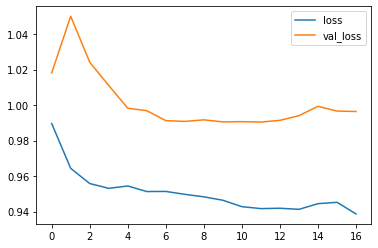

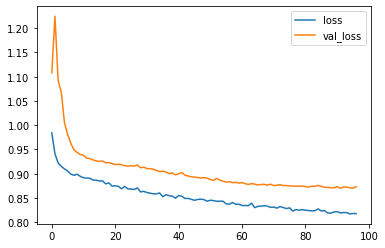

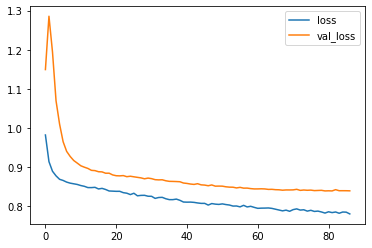

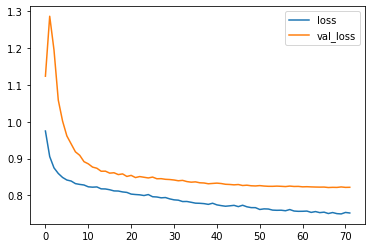

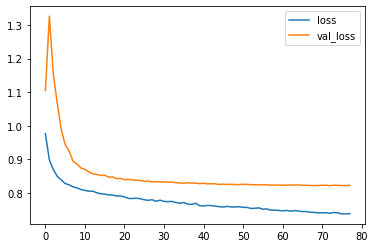

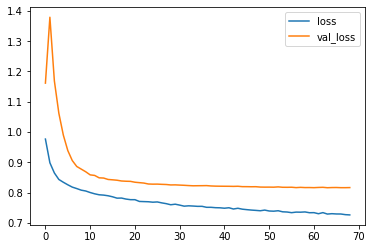

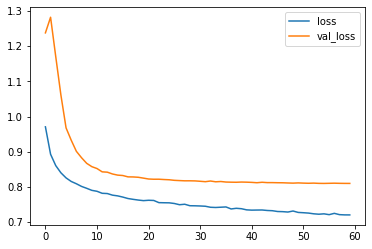

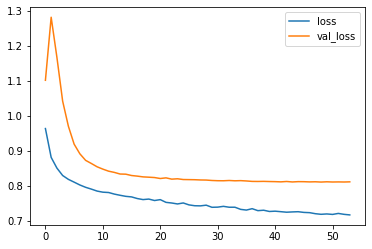

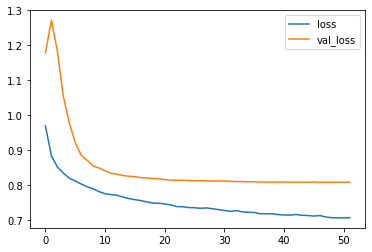

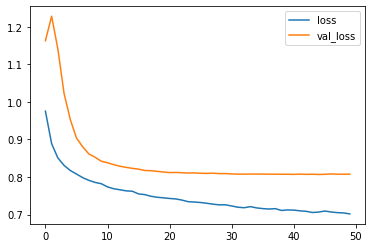

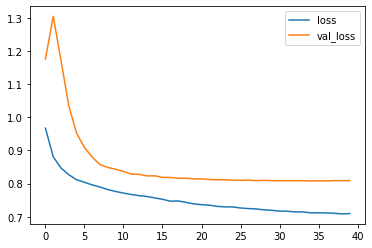

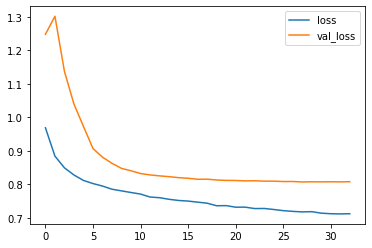

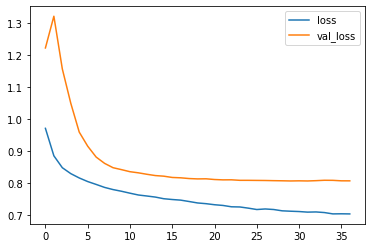

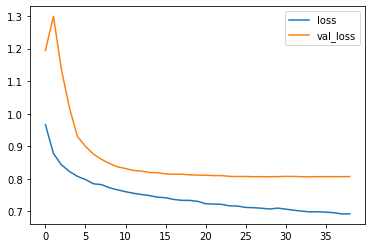

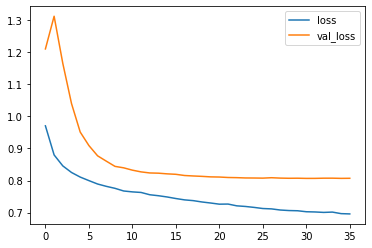

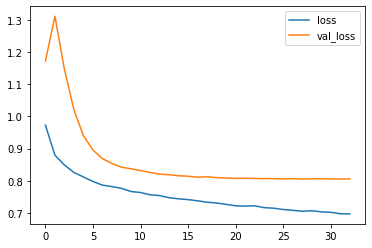

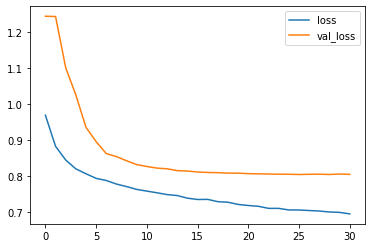

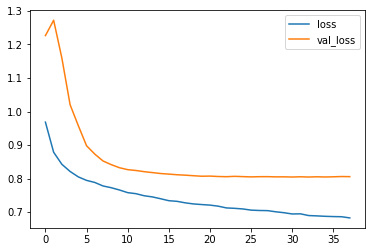

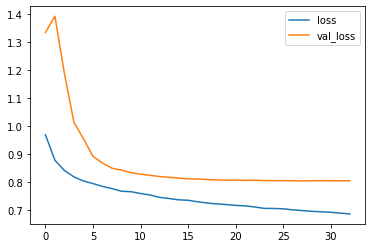

In [10]:
# Fit and evaluate 4 layer autoencoder for different sizes of bottleneck

autoenc_simple_loss = list()

latent_space_size_list = list( np.arange(1, 20, 1) )
print( latent_space_size_list )

for latent_space_size in latent_space_size_list:
    
    print("Latent space size", latent_space_size)
    
    loss, fig = get_loss_autoencoder(x_val, get_simple_autoencoder, latent_space_size, 100, verbose = '0', 
                                     rescale = True, mean = data_dict["parameters"]["mean"], std = data_dict["parameters"]["std"])
    fig
    
    autoenc_simple_loss.append( loss )

In [11]:
# Pickle the results

# put results into a dictionary
autoenc_simple_loss_dict = dict()
autoenc_simple_loss_dict["loss"] = autoenc_simple_loss
autoenc_simple_loss_dict["dim"] = latent_space_size_list

# pickle
dump_object("simple_autoencoder_loss_finegrid", autoenc_simple_loss_dict)

()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Latent space size 1
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 1, 128)            1408256   
_________________________________________________________________
batch_normalization_38 (Batc (None, 1, 128)            512       
_________________________________________________________________
dense_77 (Dense)             (None, 1, 64)             8256      
_________________________________________________________________
batch_normalization_39 (Batc (None, 1, 64)             256       
_________________________________________________________________
dense_78 (Dense)             (None, 1, 1)              65        
Total params: 1,417,345
Trainable params: 1,416,961
Non-trainable params: 384
_________________________________________________________________
None
Model: "sequen

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_94 (Dense)             (None, 1, 128)            1408256   
_________________________________________________________________
batch_normalization_50 (Batc (None, 1, 128)            512       
_________________________________________________________________
dense_95 (Dense)             (None, 1, 64)             8256      
_________________________________________________________________
batch_normalization_51 (Batc (None, 1, 64)             256       
_________________________________________________________________
dense_96 (Dense)             (None, 1, 4)              260       
Total params: 1,417,540
Trainable params: 1,417,156
Non-trainable params: 384
_________________________________________________________________
None
Model: "sequential_45"
_________________________________________________________________
Layer (type) 

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_112 (Dense)            (None, 1, 128)            1408256   
_________________________________________________________________
batch_normalization_62 (Batc (None, 1, 128)            512       
_________________________________________________________________
dense_113 (Dense)            (None, 1, 64)             8256      
_________________________________________________________________
batch_normalization_63 (Batc (None, 1, 64)             256       
_________________________________________________________________
dense_114 (Dense)            (None, 1, 7)              455       
Total params: 1,417,735
Trainable params: 1,417,351
Non-trainable params: 384
_________________________________________________________________
None
Model: "sequential_51"
_________________________________________________________________
Layer (type) 

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_133 (Dense)            (None, 1, 64)             704       
_________________________________________________________________
batch_normalization_76 (Batc (None, 1, 64)             256       
_________________________________________________________________
dense_134 (Dense)            (None, 1, 128)            8320      
_________________________________________________________________
batch_normalization_77 (Batc (None, 1, 128)            512       
_________________________________________________________________
dense_135 (Dense)            (None, 1, 11001)          1419129   
Total params: 1,428,921
Trainable params: 1,428,537
Non-trainable params: 384
_________________________________________________________________
None
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Figure(432x288)
Prediction shape (430, 1, 11001)
Loss: 0.0016785098258878697
Latent space size 14
Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_154 (Dense)            (None, 1, 128)            1408256   
_____________________________________________________

Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Figure(432x288)
Prediction shape (430, 1, 11001)
Loss: 0.001731011732768174
Latent space size 17
Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_172 (Dense)            (None, 1, 128)            1408256   
_________________________________________________________________
batch_normalization_102 (Bat (None, 1, 128)            512       
_________________________________________________________________
dense_173 (Dense)            (None, 1

Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Figure(432x288)
Prediction shape (430, 1, 11001)
Loss: 0.0017221140928778684


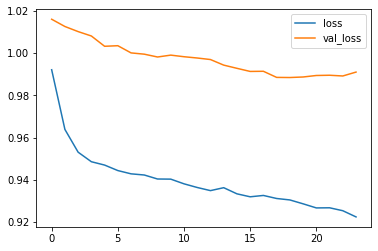

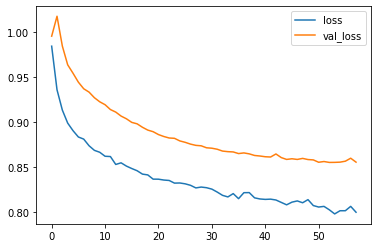

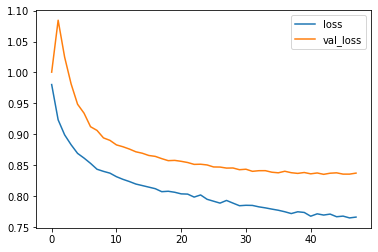

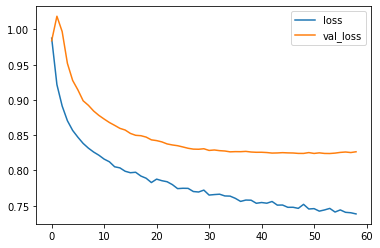

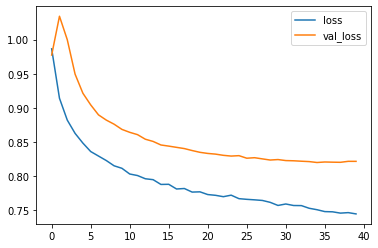

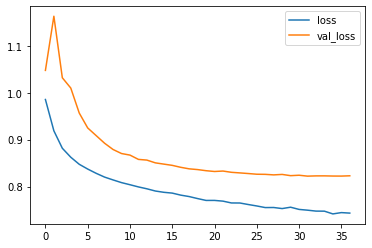

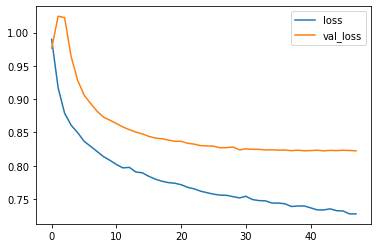

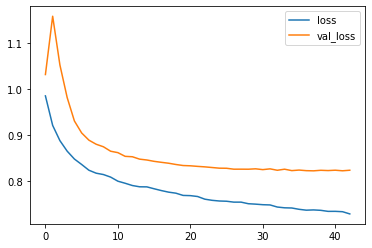

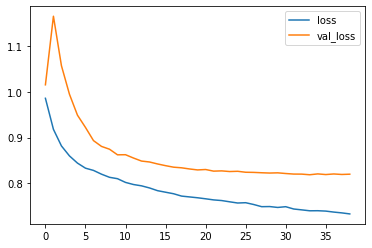

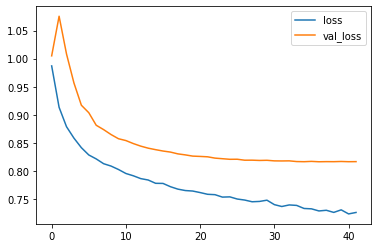

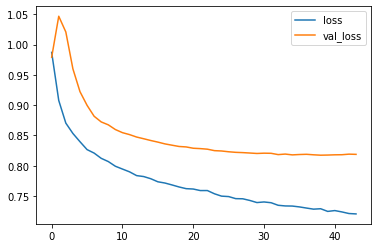

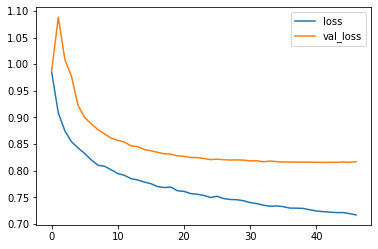

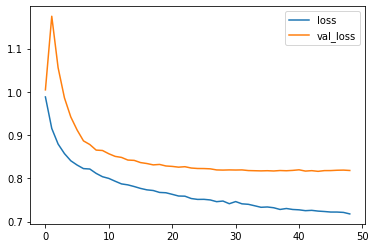

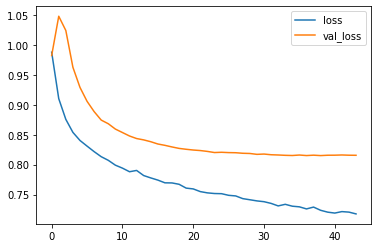

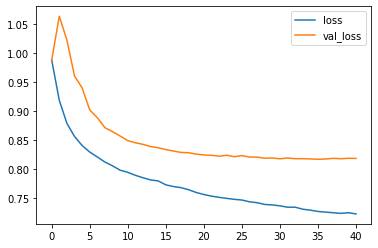

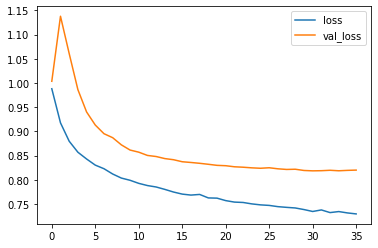

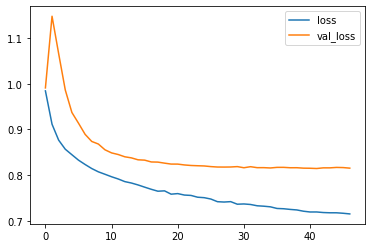

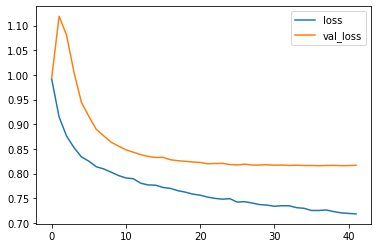

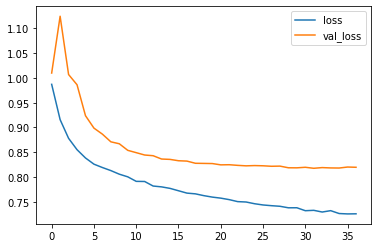

In [12]:
# Fit and evaluate 6 layer autoencoder for different sizes of bottleneck

autoenc_6layer_loss = list()

latent_space_size_list = list( np.arange(1, 20, 1) )
print( latent_space_size_list )

for latent_space_size in latent_space_size_list:
    
    print("Latent space size", latent_space_size)
    
    loss, fig = get_loss_autoencoder(x_val, get_6layer_autoencoder, latent_space_size, 100, verbose = '0',
                                    rescale = True, mean = data_dict["parameters"]["mean"], std = data_dict["parameters"]["std"])
    fig
    
    autoenc_6layer_loss.append( loss )

In [15]:
# Pickle the results for 6 layer autoencoder

# put results into a dictionary
autoenc_6layer_loss_dict = dict()
autoenc_6layer_loss_dict["loss"] = autoenc_6layer_loss
autoenc_6layer_loss_dict["dim"] = latent_space_size_list

# pickle
dump_object("6layer_autoencoder_loss_finegrid", autoenc_6layer_loss_dict)

()

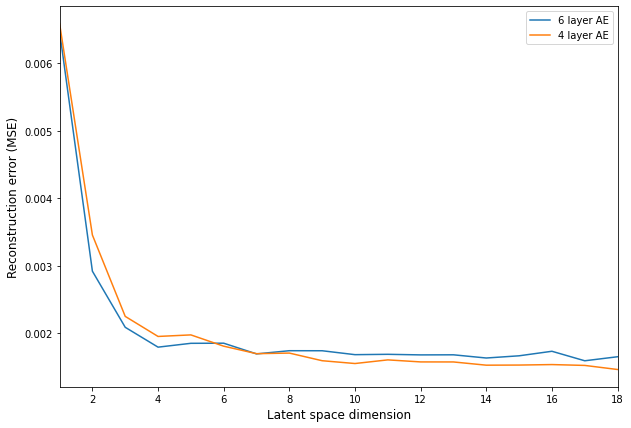

In [16]:
fig, ax = plt.subplots(figsize = (10, 7))
ax.plot(autoenc_6layer_loss_dict["dim"], autoenc_6layer_loss_dict["loss"], label = "6 layer AE")
ax.plot(autoenc_simple_loss_dict["dim"], autoenc_simple_loss_dict["loss"], label = "4 layer AE" )
ax.set_xlabel("Latent space dimension", fontsize = 12)
ax.set_ylabel("Reconstruction error (MSE)", fontsize = 12)
ax.set(xlim = (1,18) )
ax.legend();

# Final autoencoder

In [17]:
encoded_dim = 5

In [18]:
def rescale_back(observation, mean, std):
    return( observation*std + mean ) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1, 264)            2904528   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 264)            1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1, 5)              1325      
Total params: 2,906,909
Trainable params: 2,906,381
Non-trainable params: 528
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1, 264)            1584      
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 264)            1056      
_________________

11/11 [==============================] - 1s 94ms/step - loss: 0.7399 - val_loss: 0.8202
Epoch 67/100
11/11 [==============================] - 1s 100ms/step - loss: 0.7390 - val_loss: 0.8201
Figure(432x288)
Prediction shape (430, 1, 11001)
Loss: 0.001941417375879625


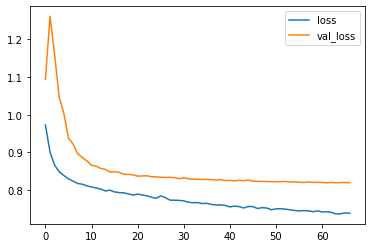

In [19]:
# Pick one model to train:

# autoencoder = get_simple_autoencoder(encoded_dim) 

encoder = Sequential([
    Dense(264, input_shape = (1, x_train.shape[2]), activation = "relu", activity_regularizer=regularizers.l1(0)),
    BatchNormalization(),
    Dense(encoded_dim, activity_regularizer=regularizers.l1(0) ),
])
print(encoder.summary())

decoder = Sequential([
    Dense(264, input_shape = (1, encoded_dim), activation = 'relu', activity_regularizer=regularizers.l1(0)),
    BatchNormalization(),
    Dense(11001, activity_regularizer=regularizers.l1(0)),
])

print(decoder.summary())

autoencoder = Model(inputs = encoder.input, outputs = decoder(encoder.output)) 


epochs = 100
verbose = 'auto'

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

autoencoder.compile(loss = 'mean_squared_error', optimizer="Adam") # since output is zero or 1 use binary loss
# default optimiser: RMS propr
autoenc_history = autoencoder.fit(train_dataset, validation_data = test_dataset, epochs = epochs,
                                verbose = verbose, callbacks = earlystopping)

fig, ax = plt.subplots()
ax.plot(autoenc_history.history["loss"], label = "loss")
ax.plot(autoenc_history.history["val_loss"], label = "val_loss")
ax.legend()

print(fig)

x_predicted_val = autoencoder.predict(test_dataset)



mean = data_dict["parameters"]["mean"]
std =  data_dict["parameters"]["std"]
x_val_rescaled = rescale_back(x_val, mean, std)
x_predicted_val_rescaled = rescale_back( x_predicted_val, mean, std )

print("Prediction shape", x_predicted_val.shape)

autoenc_loss = ((x_predicted_val_rescaled.ravel() - x_val_rescaled.numpy().ravel()) ** 2).sum().sum()/(x_val.numpy().size)
print("Loss:", autoenc_loss)

In [20]:
x_projected_autoenc_tensor = encoder(x_val)
x_projected_autoenc = x_projected_autoenc_tensor.numpy()[:, 0, :]

In [21]:
x_predicted_val = autoencoder.predict(test_dataset)[:, 0, :]
# x_reconstructed_autoenc = x_predicted_val.numpy()[:, 0, :]

In [22]:
autoenc_4layer = dict()
autoenc_4layer["x_original_val"] = x_val
autoenc_4layer["x_projected_val"] = x_projected_autoenc
autoenc_4layer["x_reconstructed_val"] = x_predicted_val
autoenc_4layer["autoenc_history"] = autoenc_history.history # dictionary with all useful info 
# autoenc_history.save('outputs/simple_autoenc_history')

In [21]:
import os
import pickle

dump_object("simple_autoenc_object", autoenc_4layer)

()

## Signal recovery

In [25]:

random.seed(44223)
random_number_list = random.sample(range(x_val.shape[0]), 40, )

random_number_list = [273, 397]

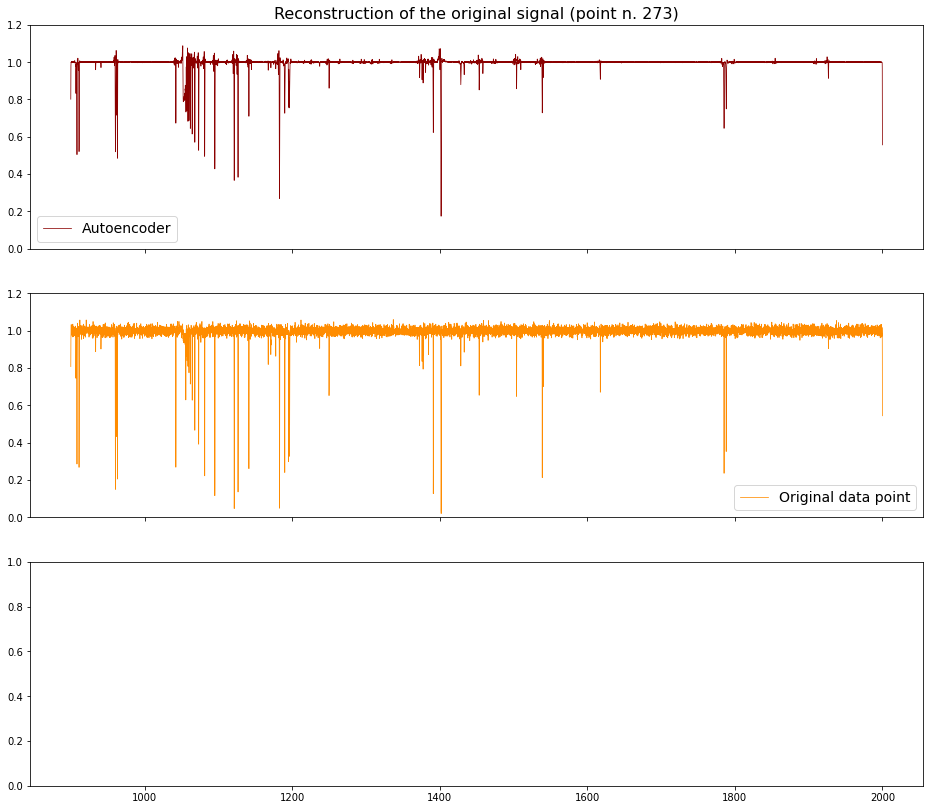

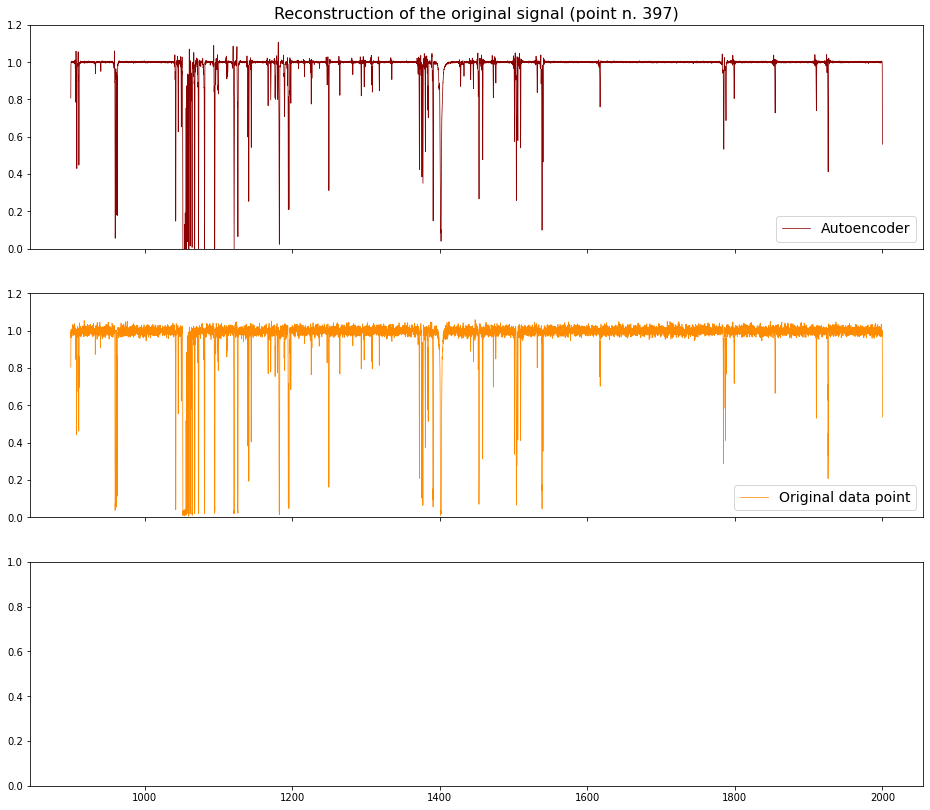

In [26]:
for random_number in random_number_list:
    x = tf.expand_dims(x_val[random_number, :], 1)
    x_projected = autoencoder.predict(x)
    x_projected_rescaled = rescale_back(x_projected, data_dict["parameters"]["mean"], data_dict["parameters"]["std"]) 
    
    x_true_rescaled = x = rescale_back(x, data_dict["parameters"]["mean"], data_dict["parameters"]["std"]) 
    
    fig, ax = plt.subplots(3, 1, sharex = True, figsize = (16, 14))
    ax[0].plot(data_dict["wavelengths"], x_projected_rescaled[0][0], label = "Autoencoder", linewidth = 0.75, color = "darkred")
    ax[0].legend(fontsize = 14)
    ax[0].set_ylim([0,1.2])
    
    ax[1].plot(data_dict["wavelengths"], x_true_rescaled[0][0], label = "Original data point", linewidth = 0.75, color = "darkorange")
    ax[1].legend(fontsize = 14)
    ax[1].set_ylim([0,1.2])
    
    ax[0].set_title("Reconstruction of the original signal (point n. " + str(random_number) + ")",
                   fontsize = (16));